In [1]:
import numpy as np
import pandas as pd
from helper.Loader import Loader

from helper.get_data import pivot_table_all

In [2]:
database = 'market_research'
table_name = 'ohlc'
start_date = "2012-01-01"
end_date = "2022-01-26"

"""
"""
wind_codes = pd.read_csv('basic_material.txt',sep=' ', header=None,)
wind_codes = wind_codes[0].to_list()
field = "symbol,date,close"
# options = "PriceAdj=DP"
loader = Loader(start_date, end_date, database, table_name, field, None)
df = loader.fetch_data(database, table_name, wind_codes, field)
df.head()
table = pivot_table_all(df, 'date', 'symbol', 'close')
# print(table)

Data found!


In [3]:
df0 = table['000629.SZ']
df0 = df0.to_frame(name='000629.SZ')
df0['Time'] = np.arange(len(df0.index))


df0 = df0[df0['Time']>5500]
df0.head()

,000629.SZ,Time
date,,
2019-07-29,25.8593,5501
2019-07-30,26.3267,5502
2019-07-31,26.1709,5503
2019-08-01,25.7036,5504
2019-08-02,25.5478,5505


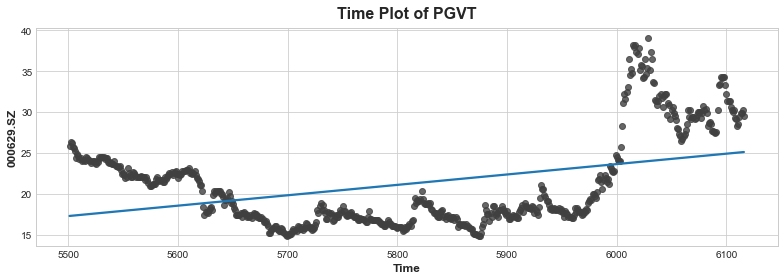

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

fig, ax = plt.subplots()
# ax.plot('Time', '000629.SZ', data=df0, color='0.75')
ax = sns.regplot(x='Time', y='000629.SZ', data=df0, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of PGVT');

df0['Lag_1'] = df0['000629.SZ'].shift(1)
df0 = df0.reindex(columns=['000629.SZ', 'Lag_1'])

df0.head()

fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='000629.SZ', data=df0, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of PGVT Sales');

In [5]:
from sklearn.linear_model import LinearRegression

# Training data
X = df0.loc[:, ['Time']]  # features
y = df0.loc[:, '000629.SZ']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

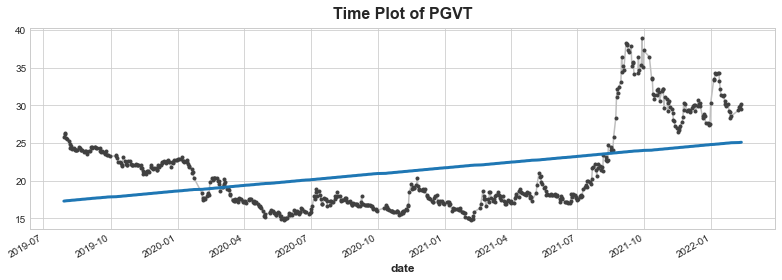

In [6]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of PGVT');

In [7]:
df0['Lag_1'] = df0['000629.SZ'].shift(1) 
# df0 = df0.reindex(columns=['000629.SZ', 'Lag_1'])

df0.head()

,000629.SZ,Time,Lag_1
date,,,
2019-07-29,25.8593,5501,NaN
2019-07-30,26.3267,5502,25.8593
2019-07-31,26.1709,5503,26.3267
2019-08-01,25.7036,5504,26.1709
2019-08-02,25.5478,5505,25.7036


In [8]:
from sklearn.linear_model import LinearRegression

X = df0.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df0.loc[:, '000629.SZ']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

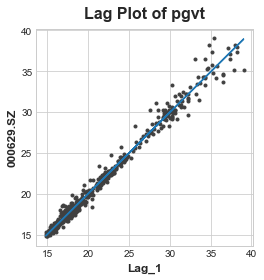

In [9]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('000629.SZ')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of pgvt');

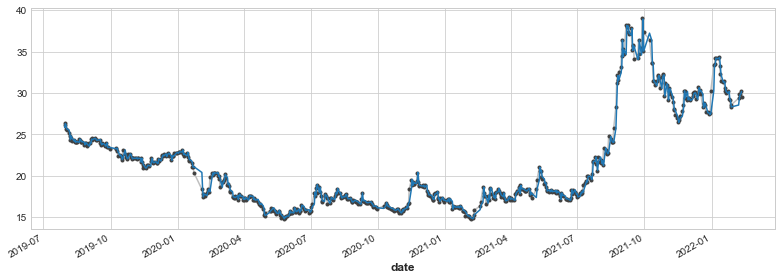

In [10]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

In [11]:
df0 = table['000629.SZ']
df0.dropna(inplace=True)  # drop missing values in the feature set
df0 = df0.to_frame(name='000629.SZ')


df0 = df0.to_period(freq ='D')
df0.index
df0.head()

,000629.SZ
date,
1996-11-15,14.35
1996-11-18,13.47
1996-11-19,13.95
1996-11-20,14.20
1996-11-21,14.25


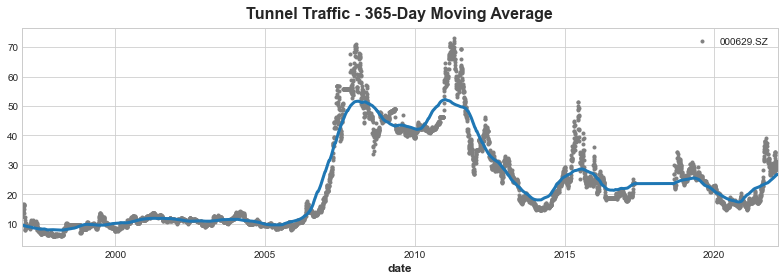

In [12]:
moving_average = df0.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df0.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In [22]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df0.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
1996-11-15,1.0,1.0,1.0,1.0
1996-11-18,1.0,2.0,4.0,8.0
1996-11-19,1.0,3.0,9.0,27.0
1996-11-20,1.0,4.0,16.0,64.0
1996-11-21,1.0,5.0,25.0,125.0


In [23]:
from sklearn.linear_model import LinearRegression

y = df0['000629.SZ']  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

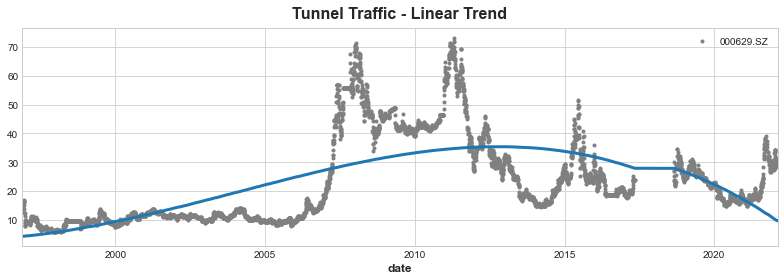

In [24]:
ax = df0.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [25]:
X = dp.out_of_sample(steps=180)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2022-02-12    9.609337
2022-02-13    9.579718
2022-02-14    9.550079
2022-02-15    9.520421
2022-02-16    9.490742
Freq: D, dtype: float64

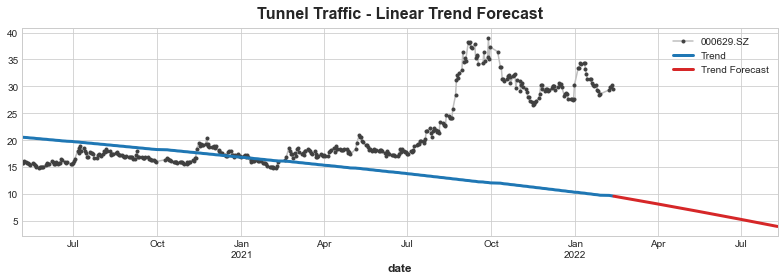

In [26]:
ax = df0["2020-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2020-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

(Optional) Fit trend with splines
Splines are a nice alternative to polynomials when you want to fit a trend. The Multivariate Adaptive Regression Splines (MARS) algorithm in the pyearth library is powerful and easy to use. There are a lot of hyperparameters you may want to investigate.

# Clone repo
!pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev

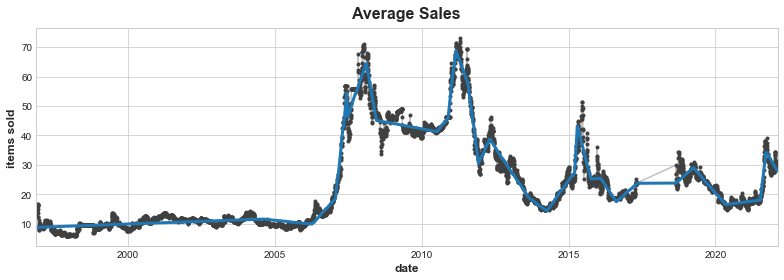

In [28]:
from pyearth import Earth

# Target and features are the same as before
y = y.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

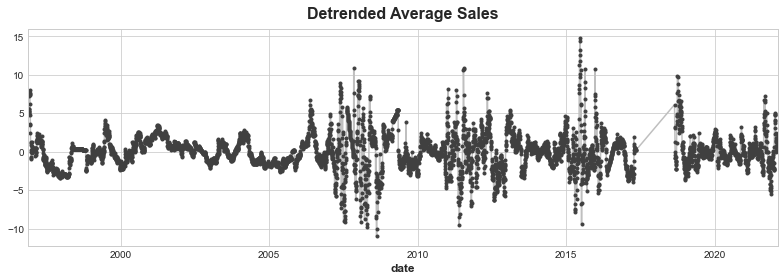

In [29]:
y_detrended = y - y_pred   # remove the trend from store_sales

y_detrended.plot(**plot_params, title="Detrended Average Sales");